# Maximizing Customer Retention: Fairway Bank (Preprocessing)

To help Fairway Bank reduce customer churn to 10%, we will build a model to predict churn. First, we must preprocess our data to prepare it for machine learning. We will also explore dimensionality reduction and cluster anaylsis. Exploratory data analysis can be found __[here](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/notebooks/01_eda.ipynb)__.

## Load Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [9]:
# As we will be preprocessing data values, save original copy of dataframe for additional exploratory analysis

df = pd.read_csv('bank_2.csv', index_col=0)
df_og = df.copy()

In [10]:
df.head()

,credit_score,country,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,complain,satisfaction,card_type,points
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   credit_score  10000 non-null  int64  
 1   country       10000 non-null  object 
 2   gender        10000 non-null  object 
 3   age           10000 non-null  int64  
 4   tenure        10000 non-null  int64  
 5   balance       10000 non-null  float64
 6   num_products  10000 non-null  int64  
 7   credit_card   10000 non-null  int64  
 8   active        10000 non-null  int64  
 9   salary        10000 non-null  float64
 10  churn         10000 non-null  int64  
 11  complain      10000 non-null  int64  
 12  satisfaction  10000 non-null  int64  
 13  card_type     10000 non-null  object 
 14  points        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.2+ MB


## One Hot Encode Categorical Data

In [17]:
# Convert gender column to 0's and 1's

df.loc[df['gender'] == 'Female', 'gender'] = 0
df.loc[df['gender'] == 'Male', 'gender'] = 1
df['gender'] = df['gender'].astype(int)

In [19]:
# One-hot encode country and card type columns

df.rename(columns={'card_type': 'card'}, inplace=True)

df.loc[df['card'] == 'DIAMOND', 'card'] = 'D'
df.loc[df['card'] == 'GOLD', 'card'] = 'G'
df.loc[df['card'] == 'PLATINUM', 'card'] = 'P'
df.loc[df['card'] == 'SILVER', 'card'] = 'S'

df.loc[df['country'] == 'France', 'country'] = 'F'
df.loc[df['country'] == 'Spain', 'country'] = 'S'
df.loc[df['country'] == 'Germany', 'country'] = 'G'

dummies = pd.get_dummies(df[['country', 'card']], dtype=int)
df = pd.concat([df.drop(columns=['country', 'card']), dummies], axis=1)

In [21]:
df.head()

,credit_score,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,complain,satisfaction,points,country_F,country_G,country_S,card_D,card_G,card_P,card_S
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,2,464,1,0,0,1,0,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,1,3,456,0,0,1,1,0,0,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,3,377,1,0,0,1,0,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,5,350,1,0,0,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,5,425,0,0,1,0,1,0,0


In [23]:
df.dtypes

credit_score      int64
gender            int64
age               int64
tenure            int64
balance         float64
num_products      int64
credit_card       int64
active            int64
salary          float64
churn             int64
complain          int64
satisfaction      int64
points            int64
country_F         int64
country_G         int64
country_S         int64
card_D            int64
card_G            int64
card_P            int64
card_S            int64
dtype: object

In [25]:
# Save dataframe with all numerical values

df.to_csv('bank_3.csv')

Now we have a dataframe ready for machine learning. Given the variance in values, we will also build another dataframe that bins continuous numerical values into a  discrete number of bins.

## Combine Continuous Data Into Discrete Bins

In [29]:
# Evaluate continuous numerical variables

df_bins = df[['credit_score', 'age', 'balance', 'salary', 'points']]
df_bins.describe()

,credit_score,age,balance,salary,points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881,606.515100
std,96.653299,10.487806,62397.405202,57510.492818,225.924839
min,350.000000,18.000000,0.000000,11.580000,119.000000
25%,584.000000,32.000000,0.000000,51002.110000,410.000000
50%,652.000000,37.000000,97198.540000,100193.915000,605.000000
75%,718.000000,44.000000,127644.240000,149388.247500,801.000000
max,850.000000,92.000000,250898.090000,199992.480000,1000.000000


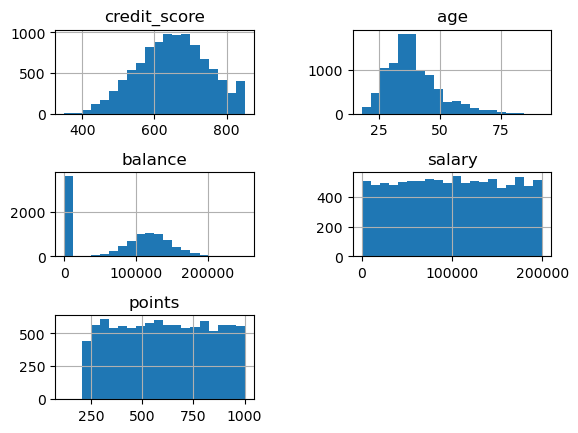

In [31]:
df_bins.hist(bins=20);
plt.subplots_adjust(hspace=0.7, wspace=0.5);

We must consult with stakeholders to get desired bin ranges fo each of these features. Since we are responsible for mocking up an initial blueprint prior to consultation, we will here base bins upon common ranges and/or values that relevantly divide the data:

- __[credit_score](https://time.com/personal-finance/article/different-credit-scoring-ranges/)__
    - 300-579 (Bad)
    - 580-669 (Fair)
    - 670-799 (Good)
    - 800-850 (Excellent)
- __[age](https://www.pickfu.com/demographic-segmentation)__
    - 18-24
    - 25-34
    - 35-44
    - 45-54
    - 55-64
    - 65+
- balance
    - 0
    - 1-99.99k
    - 100k-149.99k
    - 150k+
- salary
    - 0-49.99k
    - 50k-99.99k
    - 100k-149.99k
    - 150k+
- points
    - 0-299
    - 300-399
    - 400-499
    - 500-599
    - 600-699
    - 700-799
    - 800-899
    - 900+

In [34]:
# Make copy of existing dataframe

bdf = df.copy()

# Convert values to bin labels

bdf.loc[bdf['credit_score'] < 580, 'credit_score'] = 0
bdf.loc[(bdf['credit_score'] >= 580) & (bdf['credit_score'] < 670), 'credit_score'] = 1
bdf.loc[(bdf['credit_score'] >= 670) & (bdf['credit_score'] < 800), 'credit_score'] = 2
bdf.loc[bdf['credit_score'] >= 800, 'credit_score'] = 3

bdf.loc[bdf['age'] < 25, 'age'] = 0
bdf.loc[(bdf['age'] >= 25) & (bdf['age'] < 35), 'age'] = 1
bdf.loc[(bdf['age'] >= 35) & (bdf['age'] < 45), 'age'] = 2
bdf.loc[(bdf['age'] >= 45) & (bdf['age'] < 55), 'age'] = 3
bdf.loc[(bdf['age'] >= 55) & (bdf['age'] < 65), 'age'] = 4
bdf.loc[bdf['age'] >= 65, 'age'] = 5

bdf.loc[bdf['balance'] == 0, 'balance'] = 0
bdf.loc[(bdf['balance'] > 0) & (bdf['balance'] < 100_000), 'balance'] = 1
bdf.loc[(bdf['balance'] >= 100_000) & (bdf['balance'] < 150_000), 'balance'] = 2
bdf.loc[bdf['balance'] >= 150_000, 'balance'] = 3
bdf['balance'] = bdf['balance'].astype(int)

bdf.loc[bdf['salary'] < 50_000, 'salary'] = 0
bdf.loc[(bdf['salary'] >= 50_000) & (bdf['salary'] < 100_000), 'salary'] = 1
bdf.loc[(bdf['salary'] >= 100_000) & (bdf['salary'] < 150_000), 'salary'] = 2
bdf.loc[bdf['salary'] >= 150_000, 'salary'] = 3
bdf['salary'] = bdf['salary'].astype(int)

bdf.loc[bdf['points'] < 300, 'points'] = 0
bdf.loc[(bdf['points'] >= 300) & (bdf['points'] < 400), 'points'] = 1
bdf.loc[(bdf['points'] >= 400) & (bdf['points'] < 500), 'points'] = 2
bdf.loc[(bdf['points'] >= 500) & (bdf['points'] < 600), 'points'] = 3
bdf.loc[(bdf['points'] >= 600) & (bdf['points'] < 700), 'points'] = 4
bdf.loc[(bdf['points'] >= 700) & (bdf['points'] < 800), 'points'] = 5
bdf.loc[(bdf['points'] >= 800) & (bdf['points'] < 900), 'points'] = 6
bdf.loc[bdf['points'] >= 900, 'points'] = 7

In [36]:
# Older version using pd.cut to divide based on ranges in actual dataframe rather than predisposed ranges
# Switching to predisposed ranges is more relevant to real world business scenario

# df_bins['credit_score'] = pd.cut(df_bins['credit_score'], 6)
# df_bins['age'] = pd.cut(df_bins['age'], 9)
# df_bins['balance'] = pd.cut(df_bins['balance'], 5)
# df_bins['salary'] = pd.cut(df_bins['salary'], 9)
# df_bins['points'] = pd.cut(df_bins['points'], 10)

# bdf = df.copy()

# bdf['credit_score'] = pd.cut(bdf['credit_score'], 6, labels=[i for i in range(6)]).astype(int)
# bdf['age'] = pd.cut(bdf['age'], 9, labels=[i for i in range(9)]).astype(int)
# bdf['balance'] = pd.cut(bdf['balance'], 5, labels=[i for i in range(5)]).astype(int)
# bdf['salary'] = pd.cut(bdf['salary'], 9, labels=[i for i in range(9)]).astype(int)
# bdf['points'] = pd.cut(bdf['points'], 10, labels=[i for i in range(10)]).astype(int)

# Add columns with bin labels that correspond with each unique range

# for x in list(df_bins.columns):
#     for i, y in enumerate(df_bins[x].unique().sort_values()):
#         df_bins.loc[df_bins[x] == y, x + '_bin'] = i

# for x in list(df_bins.columns)[5:]:
#     df_bins[x] = df_bins[x].astype(int)

# Combine adjacent bins at beginning or end of range with low value counts

# bdf.loc[bdf['credit_score'] == 0, 'credit_score'] = 1
# df_bins.loc[df_bins['credit_score_bin'] == 0, 'credit_score_bin'] = 1

# bdf.loc[bdf['age'].isin([6, 7, 8]), 'age'] = 5
# df_bins.loc[df_bins['age_bin'].isin([6, 7, 8]), 'age_bin'] = 5

# bdf.loc[bdf['tenure'] == 0, 'tenure'] = 1
# df.loc[df['tenure'] == 10, 'tenure'] = 9

# bdf.loc[bdf['balance'] == 4, 'balance'] = 3
# df_bins.loc[df_bins['balance_bin'] == 4, 'balance_bin'] = 3

# bdf.loc[bdf['num_products'] == 4, 'num_products'] = 3

# bdf.loc[bdf['points'] == 0, 'points'] = 1
# df_bins.loc[df_bins['points_bin'] == 0, 'points_bin'] = 1

In [38]:
# Check number of observations per label per column

for x in list(bdf.columns):
    print(bdf[x].value_counts())

credit_score
2    3652
1    3331
0    2362
3     655
Name: count, dtype: int64
gender
1    5457
0    4543
Name: count, dtype: int64
age
2    3981
1    3222
3    1458
4     600
0     457
5     282
Name: count, dtype: int64
tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64
balance
2    3830
0    3617
1    1584
3     969
Name: count, dtype: int64
num_products
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64
credit_card
1    7055
0    2945
Name: count, dtype: int64
active
1    5151
0    4849
Name: count, dtype: int64
salary
2    2555
1    2537
3    2455
0    2453
Name: count, dtype: int64
churn
0    7962
1    2038
Name: count, dtype: int64
complain
0    7956
1    2044
Name: count, dtype: int64
satisfaction
3    2042
2    2014
4    2008
5    2004
1    1932
Name: count, dtype: int64
points
3    1350
4    1280
5    1275
1    1271
7    1269
6    1243
2    1238
0    1074
Name

In [40]:
# Since we only have 60 customers in the sample with 4 products, we will combine these with those with 3 products
# We thus have labels for customers with 1, 2, or 3+ products

bdf.loc[bdf['num_products'] == 4, 'num_products'] = 3

In [42]:
bdf.head()

,credit_score,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,complain,satisfaction,points,country_F,country_G,country_S,card_D,card_G,card_P,card_S
0,1,0,2,2,0,1,1,1,2,1,1,2,2,1,0,0,1,0,0,0
1,1,0,2,1,1,1,0,1,2,0,1,3,2,0,0,1,1,0,0,0
2,0,0,2,8,3,3,1,0,2,1,1,3,1,1,0,0,1,0,0,0
3,2,0,2,1,0,2,0,0,1,0,0,5,1,1,0,0,0,1,0,0
4,3,0,2,2,2,1,1,1,1,0,0,5,2,0,0,1,0,1,0,0


Great! Now that we have a binned dataframe, let's explore dimensionality reduction and a cluster analysis.

## Train / Test Split

In [46]:
# Apply 80 / 20 split into train and test sets

X = bdf.drop(columns='churn')
y = bdf['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [48]:
print(f'X_train: {X_train.shape[0]} samples')
print(f'X_test: {X_test.shape[0]} samples')

X_train: 8000 samples
X_test: 2000 samples


## Scale Data

In [51]:
# Scale all values between 0 and 1

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Dimensionality Reduction

In [54]:
# Implement Umap embedding to project all features onto a 2 dimensional plane

reducer = umap.UMAP(random_state=42)
reducer.fit(X_train_scaled)
train_embedding = reducer.transform(X_train_scaled)
test_embedding = reducer.transform(X_test_scaled)

In [55]:
train_embedding

array([[ 1.1573519 , -3.8637831 ],
       [ 0.05102752,  8.535957  ],
       [ 6.670605  , 14.999217  ],
       ...,
       [ 0.1712929 ,  8.18539   ],
       [-6.8518457 , -3.7768016 ],
       [ 7.424006  , 12.933095  ]], dtype=float32)

In [56]:
test_embedding

array([[18.638247  ,  1.3861629 ],
       [-8.597023  , -6.8388925 ],
       [ 1.2187009 , -6.7246947 ],
       ...,
       [ 5.911498  ,  1.1003162 ],
       [-3.7907677 , -0.21655093],
       [ 0.69007266, 12.688659  ]], dtype=float32)

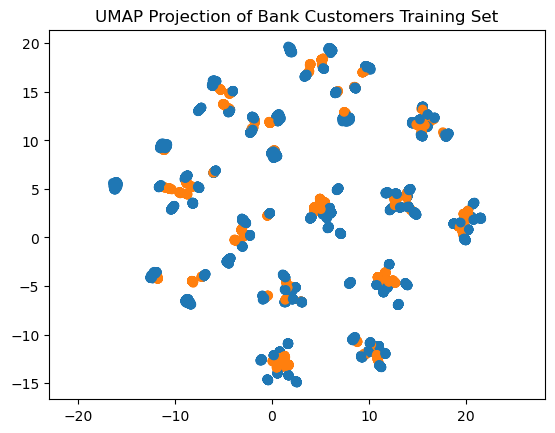

In [60]:
plt.scatter(train_embedding[:,0], train_embedding[:,1],
            c=[sns.color_palette()[x] for x in y_train.map({0:0, 1:1})]);
plt.gca().set_aspect('equal', 'datalim');
plt.title('UMAP Projection of Bank Customers Training Set');

We can see from the embeddings that there is some separability between churn and retain, indicated by areas where each hue is clumped. We may use these embeddings as additional features to feed to our predictive models.

In [63]:
# Add embedding features to train and test dataframes

X_train['umap_1'] = train_embedding[:,0]
X_train['umap_2'] = train_embedding[:,1]

X_test['umap_1'] = test_embedding[:,0]
X_test['umap_2'] = test_embedding[:,1]

## K-Means Clustering

In [66]:
# Implement K-Means clustering, trying values for k from 2 to 19

wcss = [] # within cluster sum of squares
ss = [] # silhouette scores

for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_scaled)
    wcss.append(km.inertia_)
    ss.append(silhouette_score(X_train_scaled, km.labels_))

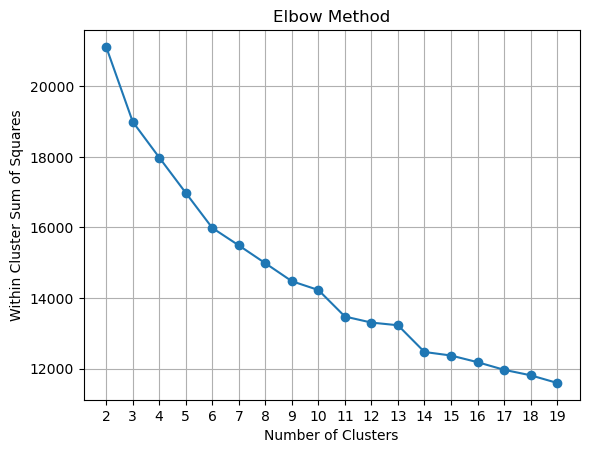

In [67]:
# Consider optimum number of clusters from Elbow Method

plt.plot(range(2,20), wcss, marker='o');
plt.grid();
plt.xticks([x for x in range(2,20)]);
plt.xlabel('Number of Clusters');
plt.ylabel('Within Cluster Sum of Squares');
plt.title('Elbow Method');

We see a few elbows around k = 6, 10, and 13, though it is difficult to discern a noticeable ideal k value with the Elbow Method.

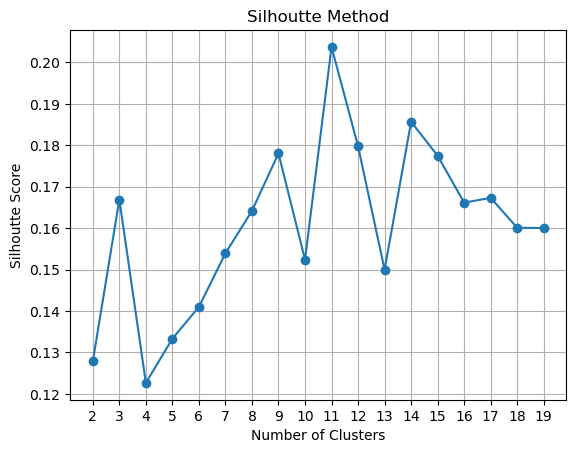

In [72]:
# Consider optimum number of clusters using Silhoutte Method

plt.plot(range(2,20), ss, marker='o');
plt.grid();
plt.xticks([x for x in range(2,20)]);
plt.xlabel('Number of Clusters');
plt.ylabel('Silhoutte Score');
plt.title('Silhoutte Method');

The Silhoutte Method clearly indicates that the optimum number of clusters is 11.

In [74]:
# Fit KMeans model to scaled training dataset with 11 clusters

km = KMeans(n_clusters = 11, random_state=42)
km.fit(X_train_scaled)

KMeans(n_clusters=11, random_state=42)

In [76]:
# Predict clusters for train and test sets

train_clusters = km.predict(X_train_scaled)
test_clusters = km.predict(X_test_scaled)

In [78]:
# Add cluster labels to train and test dataframes

X_train['cluster'] = train_clusters
X_test['cluster'] = test_clusters

In [80]:
# Combine train and test dataframes

df_extra_features = pd.concat([X_train, X_test], axis=0)

# Add embedding features to primary dataframe for use in modeling

bdf = bdf.merge(df_extra_features[['umap_1', 'umap_2']], how='outer', left_index=True, right_index=True)

# Add cluster labels to original dataframe for exploratory data analysis

df_og = df_og.merge(df_extra_features[['cluster']], how='outer', left_index=True, right_index=True)

## EDA of Clusters

In [83]:
df_og.head()

,credit_score,country,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,complain,satisfaction,card_type,points,cluster
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456,5
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350,3
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425,7


In [85]:
# Create lists of numerical columns and categorical columns
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'num_products', 'salary', 'satisfaction', 'points']
cat_cols = ['gender', 'credit_card', 'active', 'churn', 'complain', 'country', 'card_type']

In [87]:
def cluster_means(x, y):
    '''This function constructs two side by side bar plots for numerical features, with clusters on the x axis 
       and the average value for selected features (as inputs) on the y axis'''
    fig, axes = plt.subplots(ncols=2, figsize=(15, 7))
    df_og.groupby('cluster')[num_cols[x]].mean().plot.bar(ax=axes[0]).set_title(f'avg {num_cols[x]}');
    df_og.groupby('cluster')[num_cols[y]].mean().plot.bar(ax=axes[1]).set_title(f'avg {num_cols[y]}');
    
def cluster_counts(x, y):
    '''This function produces two side by side bar plots showing crosstab distributions
       for each cluster and categorical variables (selected as inputs)'''
    fig, axes = plt.subplots(ncols=2, figsize=(15, 7))
    pd.crosstab(df_og['cluster'], df_og[cat_cols[x]]).plot.bar(ax=axes[0]);
    pd.crosstab(df_og['cluster'], df_og[cat_cols[y]]).plot.bar(ax=axes[1]);

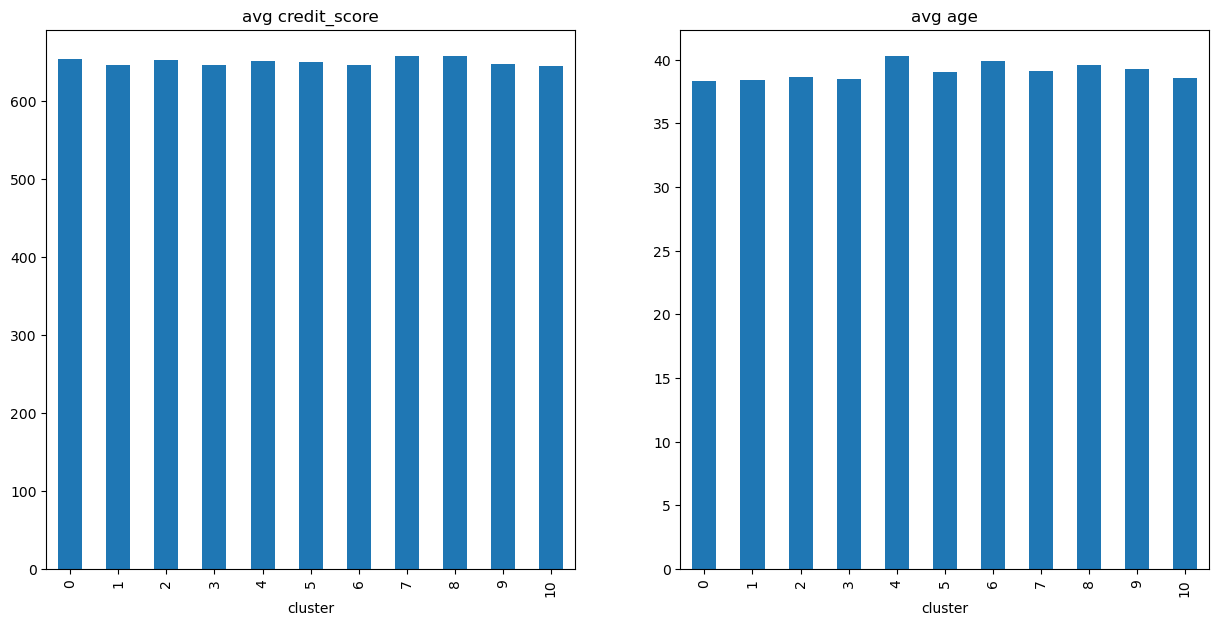

In [89]:
cluster_means(0,1)

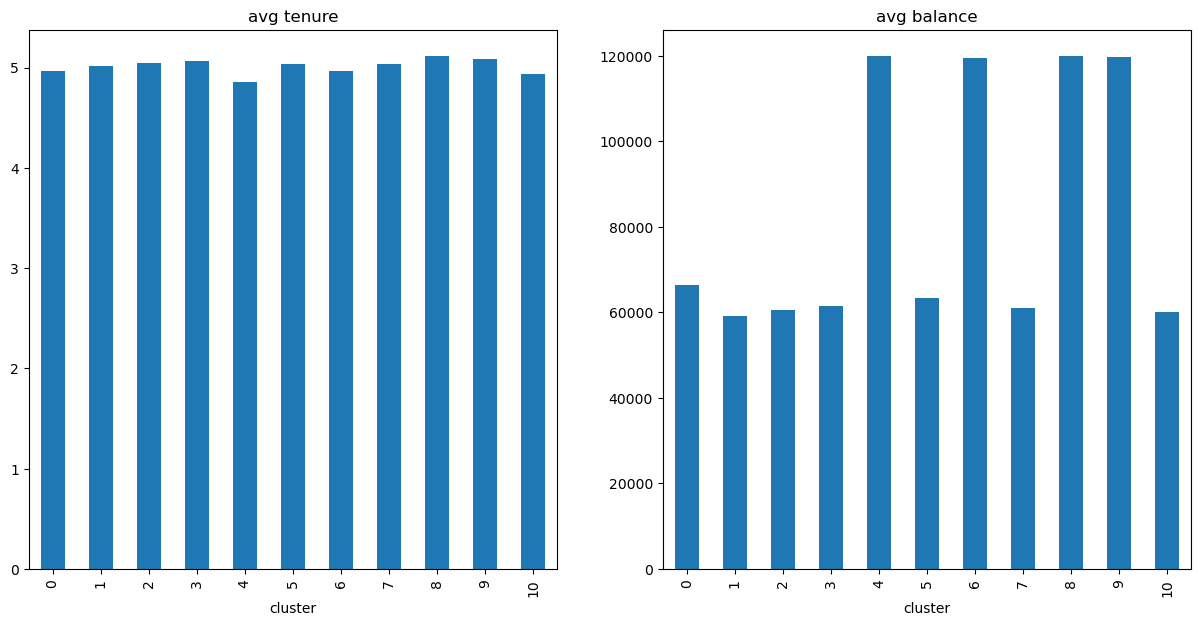

In [91]:
cluster_means(2,3)

Clusters 2, 6, 8, and 10 have noticeably higher balances.

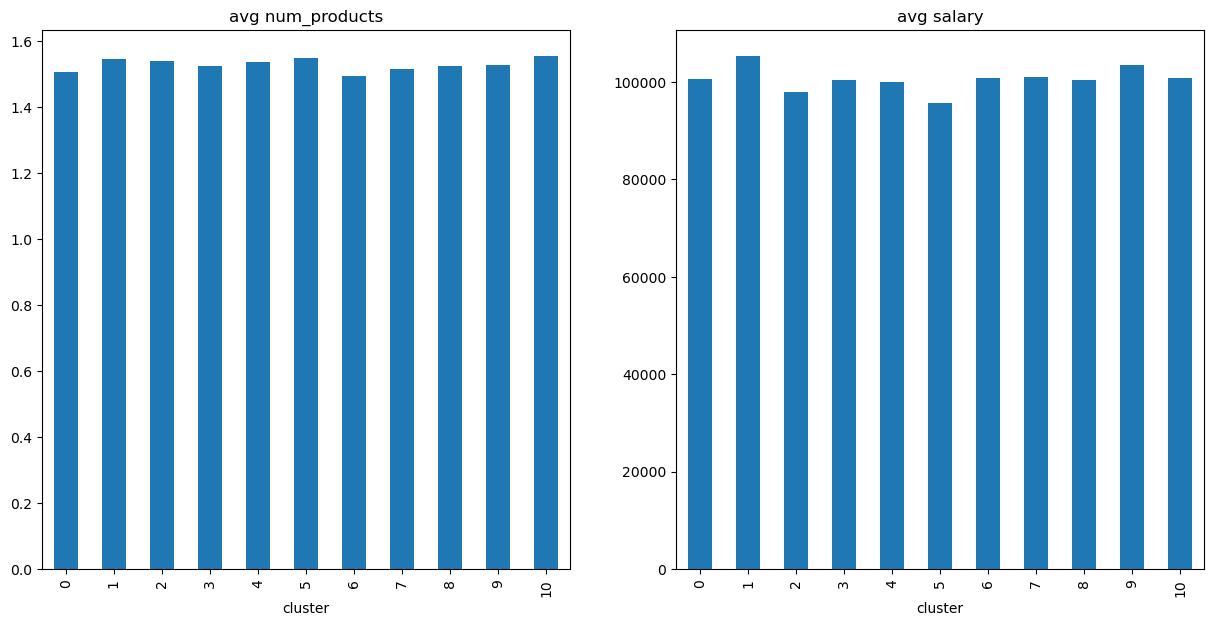

In [94]:
cluster_means(4,5)

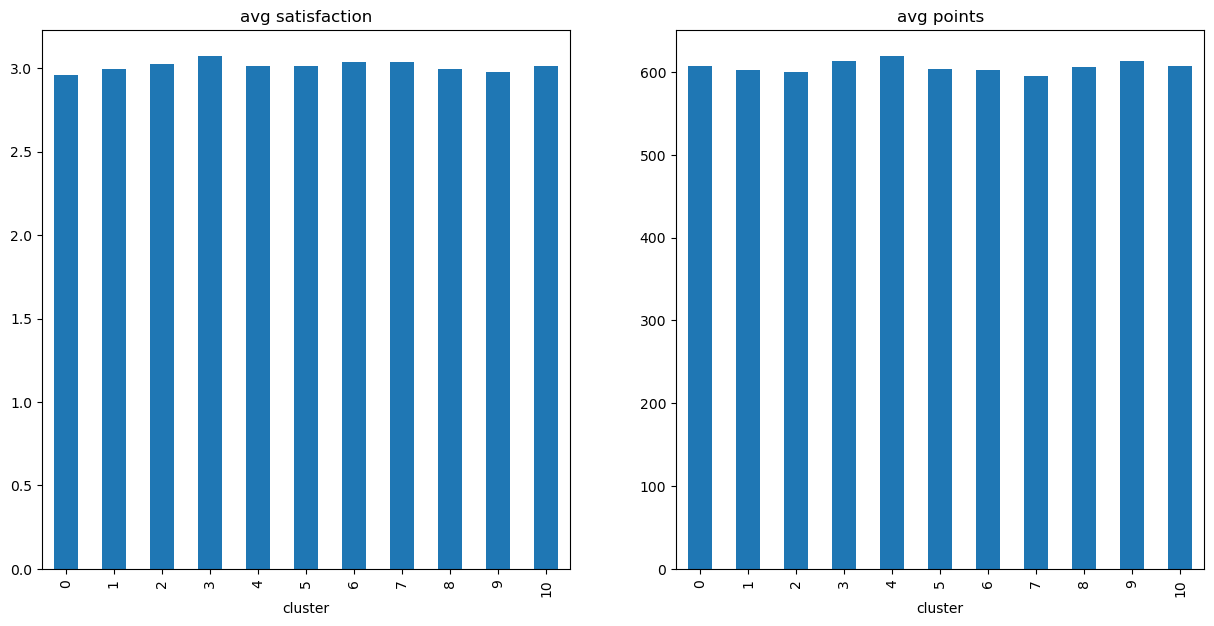

In [96]:
cluster_means(6,7)

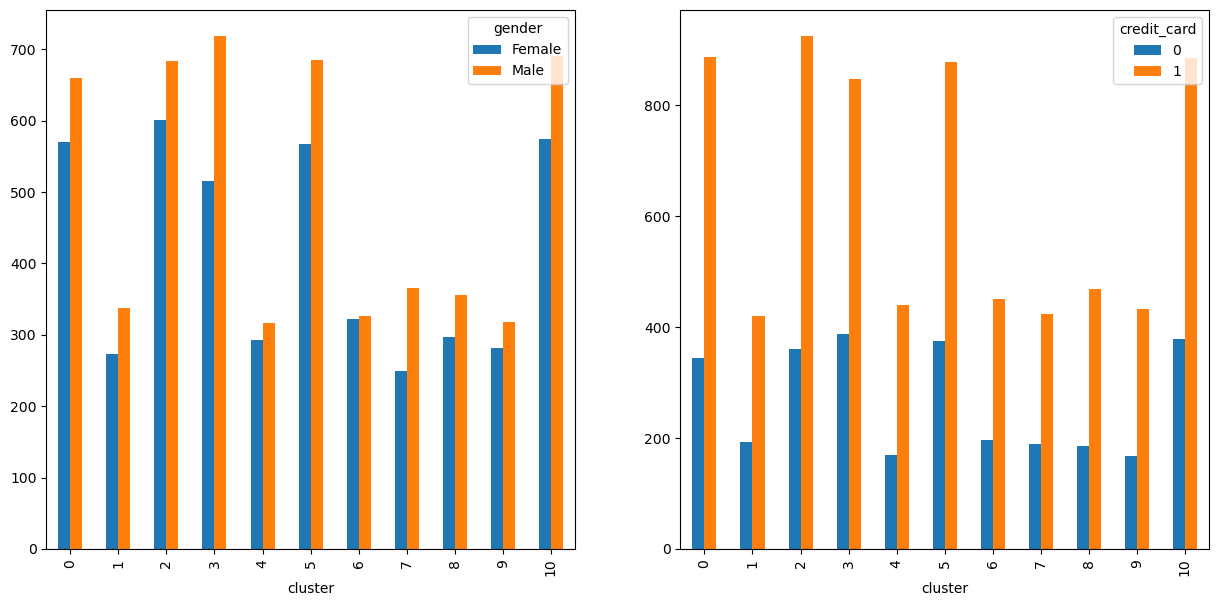

In [98]:
cluster_counts(0,1)

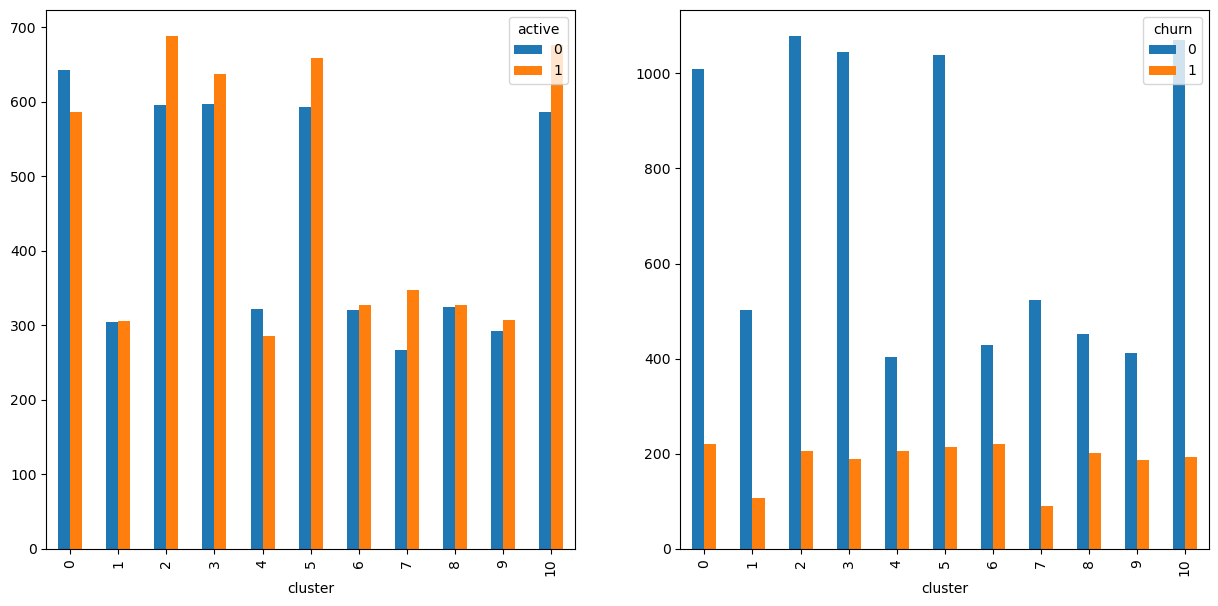

In [100]:
cluster_counts(2,3)

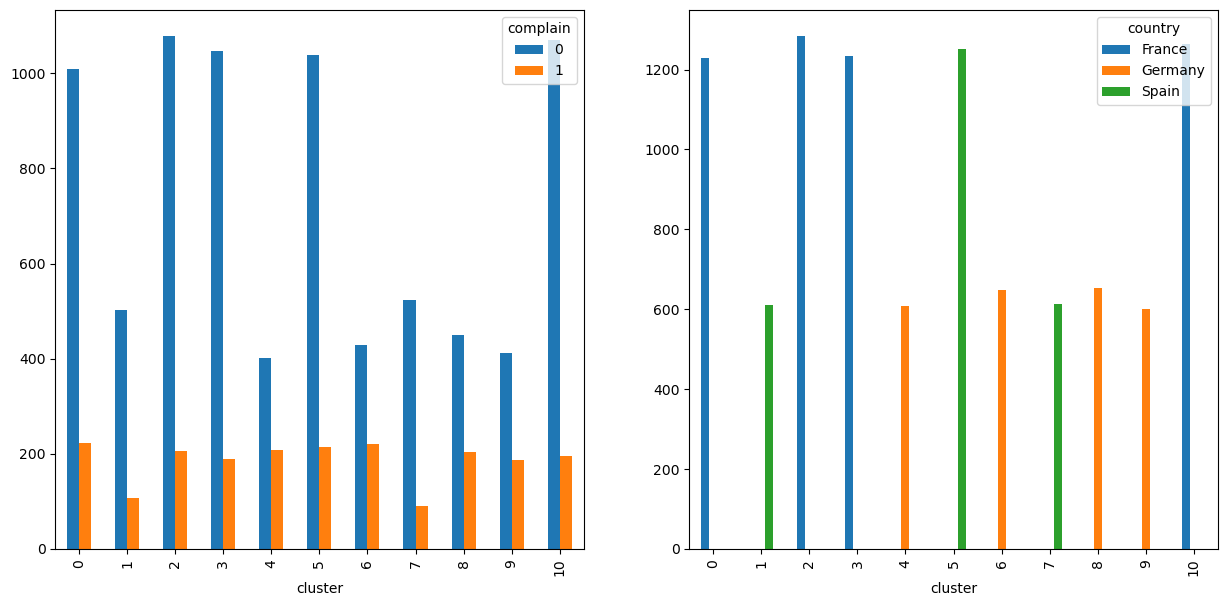

In [102]:
cluster_counts(4,5)

Clusters are distincly divided based on county.

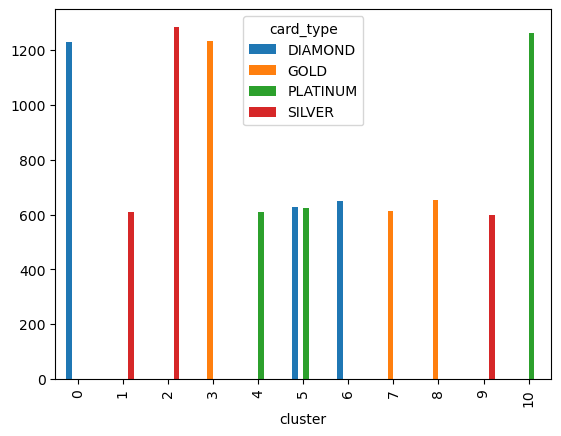

In [105]:
pd.crosstab(df_og['cluster'], df_og[cat_cols[6]]).plot.bar();

Similarly, clusters are divided based on card type.

Since cluster labels seem to be primarily based on card type and country, the clusters don't seem to add much additional insight to our input data. Moreover, they might in fact detract from future model performance by adding redundancy to the features. Thus, we will not include cluster labels in our final dataframe.

In [109]:
bdf.head()

,credit_score,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,...,points,country_F,country_G,country_S,card_D,card_G,card_P,card_S,umap_1,umap_2
0,1,0,2,2,0,1,1,1,2,1,...,2,1,0,0,1,0,0,0,-3.143583,0.786093
1,1,0,2,1,1,1,0,1,2,0,...,2,0,0,1,1,0,0,0,10.020865,-11.832602
2,0,0,2,8,3,3,1,0,2,1,...,1,1,0,0,1,0,0,0,-3.809586,-0.268657
3,2,0,2,1,0,2,0,0,1,0,...,1,1,0,0,0,1,0,0,-8.133482,3.541135
4,3,0,2,2,2,1,1,1,1,0,...,2,0,0,1,0,1,0,0,1.444620,-6.639251


## Save Data

In [1516]:
# Save dataframe with numeric data, binned categories, and cluster labels to load for predictive modeling.

bdf.to_csv('bank_4.csv')

## Summary

In this notebook we prepared out data for machine learning. We one hot encoded all categorical variables to 0's and 1's and made unique columns for each categorical feature with more than 2 categories. We also binned all continuous numeric values into discrete bins so as to reduce the complexity and nuance of inputs for our upcoming models. We based bins upon logical ranges of values that were also tuned to fit a minimum of a few hundred observations per bin. We then performed a train / test split on our data and scaled all values from a 0 to 1 range. We performed uniform manifold dimensionality reduction on the dataset to reduce the 19 features to 2 embeddings. Plotting these embeddings indicated some separability between churned and retained customers, so we added each of the embedding features to our final dataframe to be used by our upcoming predictive models. We also performed a k-means clustering and determined 11 clusters to be the ideal number. We fit the k-means clustering model to our train set and predicted labels for train and test datasets. We then performed a brief exploratory data analysis of the cluster differences and found that clusters were largely based upon country and card type. We therefore will not add the clusters to be considered by our predictive model, as they might lead to input redundancy. Next up, we will build classfication models to predict churn. See you there!